# Clasificación NO lineal

En este cuaderno vamos a realizar un proyecto completo de ML, salvo por la fase de Test.<br>
Respecto de cuadernos anteriores, aprenderemos a:
+ integrar la validación cruzada en el entrenamiento y la validación
+ evaluar el rendimiento de un modelo con la matriz de confusión y la curva ROC
+ elegir un modelo entre varios.

---
    [ES] Código de Alfredo Cuesta Infante para 'Reconocimiento de Patrones'
       @ Master Universitario en Visión Artificial, 2021, URJC (España)
    [EN] Code by Alfredo Cuesta-Infante for 'Pattern Recognition'
       @ Master of Computer Vision, 2021, URJC (Spain)

    alfredo.cuesta@urjc.es

### Preliminares 

En la siguiente celda se realizan los siguientes pasos:
1. carga de módulos genéricos
2. leer los datos y cargarlos en dataframes
2. extraer características
2. separar en TRAIN y VALID
2. seleccionar características y escalar TRAIN a [0,1]

In [1]:
#-[1]. Load data from CSV and put all in a single dataframe 'FullSet'

import numpy  as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../MyUtils/')
import MyUtils as my
seed = 1234 #<- random generator seed (comment to get randomness)

#-[2]. Load data from CSV and put all in a single dataframe 'FullSet'

FullSet_0 = pd.read_csv('../Datasets/1000ceros.csv', header=None)
FullSet_1 = pd.read_csv('../Datasets/1000unos.csv',  header=None)
FullSet = my.join_features_labels(FullSet_0,FullSet_1)

#-[3]. Convert the 'FullSet' of pixels into the set 'X_full' of features and get the set 'Y_full' of labels

theta = 0.5
X_full = my.mnist_features( FullSet.drop('label', axis=1), theta=theta )
Y_full = FullSet[['label']]

#-[4]. Split X_full into TRAIN and TEST in a single Stratified split

valid_size = 0.2
X_train, Y_train, X_valid, Y_valid = \
   my.single_stratified_split( X_full,Y_full, test_size=valid_size, random_state=seed)

#-[5]. Select the features and fit a scaler to [0,1]

from sklearn.preprocessing import MinMaxScaler

feat_selec= ['W_max1','H_max1']
scaler = MinMaxScaler()

X = scaler.fit_transform(X_train[feat_selec])
Y = Y_train.values.ravel()   

#---> X and Y are now numpy arrays ready to train a machine !!

## Diferencia con el clasificador lineal

6. aplicamos una transformación NO lineal al conjunto de entrenamiento.
7. y aprendemos un clasificador lineal sobre estas *características NO lineales*

In [2]:
#-[6]. Apply a NON-linear transformation to the features

from sklearn.preprocessing import PolynomialFeatures  
 # PolynomialFeatures created new non-linear polynomial (of N degree) features 

Ndegree = 3 #<- if = 1 there is no transformatio at all
poly_features = PolynomialFeatures(degree=Ndegree, include_bias=False)
X_poly = poly_features.fit_transform(X)

print("X transformed =  \n",X_poly)

X transformed =  
 [[0.89473684 0.84210526 0.80055402 ... 0.67415075 0.63449482 0.5971716 ]
 [0.52631579 0.84210526 0.27700831 ... 0.23327016 0.37323225 0.5971716 ]
 [0.57894737 0.89473684 0.33518006 ... 0.29989794 0.46347864 0.71628517]
 ...
 [0.42105263 0.15789474 0.17728532 ... 0.02799242 0.01049716 0.00393643]
 [0.42105263 0.84210526 0.17728532 ... 0.1492929  0.2985858  0.5971716 ]
 [0.36842105 0.94736842 0.13573407 ... 0.12859017 0.33066045 0.85026972]]


In [3]:
#-[7]. Learn a linear classifier with both X and X_poly 
from sklearn.linear_model import LogisticRegression

nolin_clf = LogisticRegression()
nolin_clf.fit(X_poly,Y) #<- this will be the non linear clf

lin_clf = LogisticRegression()
lin_clf.fit(X,Y) #<- this will be the linar clf (so we can compare them)

print('\n',"LINEAR CLF.: ",lin_clf.__dict__)
print('\n',"NON LINEAR CLF.: ",nolin_clf.__dict__)


 LINEAR CLF.:  {'penalty': 'l2', 'dual': False, 'tol': 0.0001, 'C': 1.0, 'fit_intercept': True, 'intercept_scaling': 1, 'class_weight': None, 'random_state': None, 'solver': 'lbfgs', 'max_iter': 100, 'multi_class': 'auto', 'verbose': 0, 'warm_start': False, 'n_jobs': None, 'l1_ratio': None, 'n_features_in_': 2, 'classes_': array([0., 1.]), 'coef_': array([[-0.26312067,  0.6091254 ]]), 'intercept_': array([-0.19814272]), 'n_iter_': array([8], dtype=int32)}

 NON LINEAR CLF.:  {'penalty': 'l2', 'dual': False, 'tol': 0.0001, 'C': 1.0, 'fit_intercept': True, 'intercept_scaling': 1, 'class_weight': None, 'random_state': None, 'solver': 'lbfgs', 'max_iter': 100, 'multi_class': 'auto', 'verbose': 0, 'warm_start': False, 'n_jobs': None, 'l1_ratio': None, 'n_features_in_': 9, 'classes_': array([0., 1.]), 'coef_': array([[  9.26546254,   3.33456455,  -3.28808764,   4.05013645,
         -0.80149294, -10.01866492,  -2.99736932,   0.59200976,
         -3.51894542]]), 'intercept_': array([-2.913563

### Mostrar las superficies de decisión de cada clf.
+ El clf. NO lineal recibe datos en 2D por lo que podemos pintarlos en un gráfico; pero la superficie de decisión realmente se ha aprendido como un clasificador lineal sobre las características transformadas no-linealmente; por lo que no tenemos una expresión cerrada para la superficie de decisión.
+ Para visualizarla lo que vamos a hacer es un barrido de todo el intervalo $[0,1]^2$, que es el rango de las características (recordar que las estabamos escalando) 
    + cada punto del barrido se introduce en el clf. lineal y no lineal
    + cada clf. genera un *score* o una probabilidad (según el clf. que usemos) de pertenencia a la clase 1
    + si el *score* supera un umbral *threshold* entonces se le asigna la etiqueta 1.
    + finalmente pintamos cada punto del barrido con un color según su etiqueta
    + la frontera entre los colores es la superficie de decisión.<br>
      el clf. lineal será una línea recta, mientras que en el clf. NO lineal no.

In [4]:
#--take Ngrid x Ngrid equally spaced points in [0,1]x[0,1]
Ngrid = 100
rangeX = np.linspace(0,1,Ngrid)
rangeY = np.linspace(0,1,Ngrid)
xx,yy = np.meshgrid(rangeX,rangeY)
grid_data = np.hstack( (xx.reshape([xx.size,1]),    \
                        yy.reshape([yy.size,1]) ) )

In [5]:
#--predict the score according to each clf. 
#  REMEMBER that the nolin_clf needs to transform the input !
yhat_lin = lin_clf.decision_function( grid_data )
yhat_nolin = nolin_clf.decision_function( poly_features.transform(grid_data) )

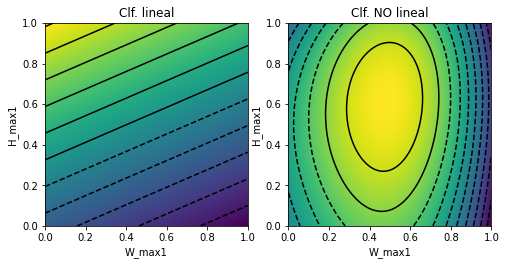

las líneas discontinuas indican valores negativos o cero


In [6]:
unit_interv = [0,1,0,1]
origin = 'lower'
plt.rcParams['figure.figsize'] = [8,8] #<- this makes the figures larger in Jupyter

plt.subplot(121)
plt.imshow(yhat_lin.reshape([Ngrid,Ngrid]), \
           origin=origin, extent=unit_interv)
plt.contour(xx,yy,yhat_lin.reshape([Ngrid,Ngrid]), \
            levels=10, origin=origin, extent=unit_interv, colors='k');
plt.xlabel(feat_selec[0]);plt.ylabel(feat_selec[1]);plt.title('Clf. lineal')

plt.subplot(122)
plt.imshow(yhat_nolin.reshape([Ngrid,Ngrid]), \
           origin=origin, extent=unit_interv)
plt.contour(xx,yy,yhat_nolin.reshape([Ngrid,Ngrid]), \
            levels=10, origin=origin, extent=unit_interv, colors='k');
plt.xlabel(feat_selec[0]);plt.ylabel(feat_selec[1]);plt.title('Clf. NO lineal')

plt.show()
print("las líneas discontinuas indican valores negativos o cero")

+ Para hacer predicciones tenemos que crear una función discriminante.
+ Nuestro clasificador es lineal en el espacio N-dimensional al que hemos mapeado nuestros ejemplos 2D. 
    + Por tanto, en ese espacio N-dim la superficie limite será un hiperplano
+ Cuando evaluamos nuevos puntos con el clasificador obtendremos valores:
    + positivos, si están a un lado del hiperplano
    + negativos, si están al otro lado
    + cero, si están justo sobre el hiperplano.
+ Para asignar la etiqueta mediante un umbral, es bueno tener los posibles valores acotados, y ahora mismo no lo están porque el clasificador devuelve valores en $(-\infty,\infty)$ .
+ Una solución es convertirlos al intervalo $[0,1]$ con la función logística
$$\tt{expit}(x) = \frac{1}{1+\exp(-x)}$$
$\tt{expit}$ es el nombre que recibe en ScyPy (nosotros la vamos a implementar en vez de importarla).
+ De esta manera, además, podemos interpretar el umbral como una medida de probabilidad.

In [7]:
#--predict the tag using a threshold

threshold = 0.5 # Set 0 < threshold < 1 to make a hard classification.

if threshold>0:  #  otherwise we would have the pictures above
    expit = lambda x: 1/(1+np.exp(-x)) # expit function converts score into probability
    y_prob = expit(yhat_nolin)
    yhat_threshold = (y_prob > threshold)
yhat_threshold = yhat_threshold.reshape([Ngrid,Ngrid])

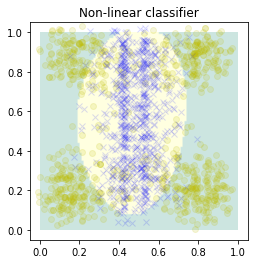

In [8]:
#--plot the non-linear outcome

plt.rcParams['figure.figsize'] = [4,4] #<- this makes the figures larger in Jupyter
cmap = 'summer'  # other choices are: 'jet' 'hot' 'cool' 'spring' 'summer' 'winter'
sigma = 0.015

plt.imshow(yhat_threshold, origin="lower", extent=unit_interv, cmap=cmap, alpha=0.2)

#--plot the training set

ix1 = Y>0
ix0 = ~ix1
x1_zeros = my.jitter(X[ix0,0],sigma=sigma)
x2_zeros = my.jitter(X[ix0,1],sigma=sigma)
x1_ones = my.jitter(X[ix1,0],sigma=sigma)
x2_ones = my.jitter(X[ix1,1],sigma=sigma)
plt.plot(x1_zeros, x2_zeros, 'yo', alpha=.15)
plt.plot(x1_ones, x2_ones, 'bx', alpha=.15)

strTitle = "Non-linear classifier"
plt.title(strTitle)
plt.axis([-0.05,1.05,-0.05,1.05])

plt.show()

## Ejercicio

+ Probar a combinar otras transformaciones con otro par de características.
+ Probar a modificar la función discriminante
+ Añadir código para evaluar estas combinaciones de manera objetiva, no sólo visual.